In [2]:
!nvidia-smi

Wed Mar  2 19:25:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##What is PyTorch?
PyTorch is a Python-based scientific computing package serving two broad purposes:

1. A replacement for NumPy to use the power of GPUs and other accelerators.
2. An automatic differentiation library that is useful to implement neural networks.

# Basic stuff

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

In [7]:
np.asarray([1,2])

array([1, 2])

In [6]:
t = torch.tensor([1,2])
print(t, t.shape)

tensor([1, 2]) torch.Size([2])


In [8]:
t = t.to(device)
print(t, t.shape)

tensor([1, 2], device='cuda:0') torch.Size([2])


## Numpy to torch tensor

In [9]:
n = np.random.rand(10,4)

In [10]:
n.shape

(10, 4)

In [11]:
torch.tensor(n).to(device)

tensor([[0.3146, 0.1349, 0.7011, 0.3700],
        [0.3609, 0.7212, 0.5452, 0.4402],
        [0.1866, 0.5982, 0.1005, 0.9245],
        [0.0997, 0.1783, 0.8340, 0.8785],
        [0.1284, 0.5297, 0.8610, 0.5636],
        [0.5754, 0.5887, 0.7785, 0.1745],
        [0.0715, 0.6386, 0.1536, 0.5599],
        [0.1816, 0.8453, 0.6852, 0.7192],
        [0.8997, 0.9864, 0.1460, 0.5553],
        [0.4672, 0.3832, 0.5687, 0.3898]], device='cuda:0',
       dtype=torch.float64)

# Autograd

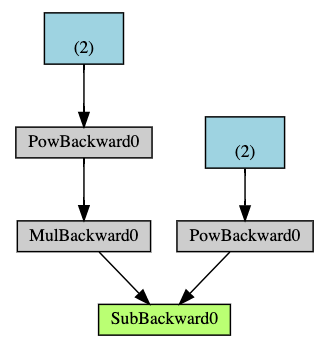

In [16]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
Q = 3*a**3 - b**2

In [19]:
Q

tensor([-12.,  65.], grad_fn=<SubBackward0>)

In [18]:
Q.sum()

tensor(53., grad_fn=<SumBackward0>)

In [ ]:
#Q -> scalar/vector? value?
#dQ/da -> scalar/vector? value?
#dQ/db -> scalar/vector? value?

In [21]:
Q.sum().backward()

In [22]:
a.grad, b.grad

(tensor([36., 81.]), tensor([-12.,  -8.]))

# Freezing model parameters

In [18]:
import torch, torchvision

model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
# for name, param in model.named_parameters():
#   print(name, "\t", param.shape, "\t", param.requires_grad)

In [21]:
model.conv1.weight.sum()

tensor(0.2768, grad_fn=<SumBackward0>)

In [22]:
prediction = model(data)

In [26]:
loss = (prediction - labels).sum()
loss

tensor(-485.1240, grad_fn=<SumBackward0>)

In [27]:
loss.backward()

In [28]:
model.conv1.weight.sum()

tensor(0.2768, grad_fn=<SumBackward0>)

In [29]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [30]:
optim.step()

In [31]:
model.conv1.weight.sum()

tensor(0.2766, grad_fn=<SumBackward0>)

In [32]:
for name, param in model.named_parameters():
  if 'layer4' not in name:
    param.requires_grad = False

In [33]:
model.conv1.weight.sum()

tensor(0.2766)

# Text Classification

In [34]:
from sklearn.datasets import fetch_20newsgroups
from pprint import  pprint
import re
from collections import Counter
import pandas as pd
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

categories = ['alt.atheism', 'talk.religion.misc','comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     categories=categories)

print(newsgroups_train.filenames.shape, newsgroups_train.target.shape)
print(newsgroups_test.target.shape, newsgroups_test.target.shape)

(2034,) (2034,)
(1353,) (1353,)


In [35]:
{ix:i for ix, i in enumerate(list(newsgroups_train.target_names))}

{0: 'alt.atheism', 1: 'comp.graphics', 2: 'sci.space', 3: 'talk.religion.misc'}

In [36]:
pprint(list(zip(newsgroups_train.target, newsgroups_train.data))[:2])

[(1,
  'From: rych@festival.ed.ac.uk (R Hawkes)\n'
  'Subject: 3DS: Where did all the texture rules go?\n'
  'Lines: 21\n'
  '\n'
  'Hi,\n'
  '\n'
  "I've noticed that if you only save a model (with all your mapping planes\n"
  'positioned carefully) to a .3DS file that when you reload it after '
  'restarting\n'
  '3DS, they are given a default position and orientation.  But if you save\n'
  'to a .PRJ file their positions/orientation are preserved.  Does anyone\n'
  'know why this information is not stored in the .3DS file?  Nothing is\n'
  'explicitly said in the manual about saving texture rules in the .PRJ '
  'file. \n'
  "I'd like to be able to read the texture rule information, does anyone "
  'have \n'
  'the format for the .PRJ file?\n'
  '\n'
  'Is the .CEL file format available from somewhere?\n'
  '\n'
  'Rych\n'
  '\n'
  '======================================================================\n'
  'Rycharde Hawkes\t\t\t\temail: rych@festival.ed.ac.uk\n'
  'Virtual Environm

In [37]:
def cleanse(txt):
  txt = txt.lower().replace("\n","")
  txt = re.sub(r"[^a-z0-9 ]+", r" ", txt)
  txt = re.sub(r"\s+", r" ", txt).strip()
  return txt


def get_vocab(data):
  data = " ".join([cleanse(i) for i in data])
  return data.split()

In [38]:
train_words = get_vocab(newsgroups_train.data)

In [39]:
len(train_words), len(set(train_words))

(623827, 48201)

In [40]:
word_freq = pd.DataFrame(Counter(train_words).most_common(), columns = ['word', 'freq'])

In [41]:
word_freq.shape

(48201, 2)

In [42]:
# How many words appear more than once ?
word_freq[word_freq['freq'] > 1].shape[0]/word_freq.shape[0]

0.44507375365656315

In [43]:
# word_freq = word_freq[word_freq['freq'] > 1]
# word_freq.head()

In [44]:
word_freq.index = word_freq.index+1

In [45]:
id2word = word_freq.to_dict()['word']
word2id = {v:k for k,v in id2word.items()}

In [46]:
id2word[0] = 'PAD'
id2word[max(id2word.keys()) + 1] = 'UNK'

word2id['PAD'] = 0
word2id['UNK'] = max(word2id.values()) + 1

In [47]:
def encode(txt):
  return [word2id.get(i, word2id['UNK']) for i in txt.split()]

def decode(lst):
  return " ".join([id2word.get(i, 'UNK') for i in lst])

In [48]:
decode(encode(cleanse(newsgroups_train.data[0])))

'from rych festival ed ac uk r hawkes subject 3ds where did all the texture rules go lines 21hi i ve noticed that if you only save a model with all your mapping planespositioned carefully to a 3ds file that when you reload it after restarting3ds they are given a default position and orientation but if you saveto a prj file their positions orientation are preserved does anyoneknow why this information is not stored in the 3ds file nothing isexplicitly said in the manual about saving texture rules in the prj file i d like to be able to read the texture rule information does anyone have the format for the prj file is the cel file format available from somewhere rych rycharde hawkes email rych festival ed ac ukvirtual environment laboratorydept of psychology tel 44 31 650 3426univ of edinburgh fax 44 31 667 0150'

In [49]:
# Analyzing document lengths
lens = [len(cleanse(i).split()) for i in newsgroups_train.data]

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


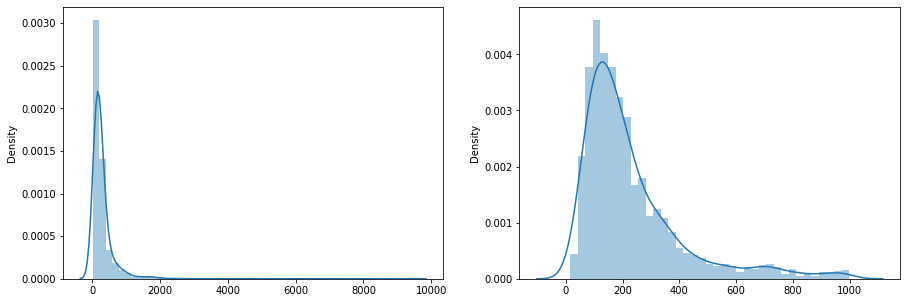

In [51]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(lens)
plt.subplot(1,2,2)
sns.distplot([i for i in lens if i <= 1000])
plt.show()

In [52]:
def max_padding(x, y, max_len=256):
  ix = [ix for ix, i in enumerate(x) if len(i) <= max_len and len(i)>0]
  x = np.asarray(x)[ix].tolist()
  y = np.asarray(y)[ix].tolist()
  return [(i + [0]*(max_len - len(i))) for i in x], [len(i) for i in x], y

In [53]:
def format_data(x, y, to_tensor=True):
  cleansed_data = [cleanse(i) for i in x]
  encoded_data = [encode(i) for i in cleansed_data]
  x, len, y = max_padding(encoded_data, y)
  if to_tensor:
    return torch.tensor(x), torch.tensor(len),torch.tensor(y)

In [54]:
X_train, X_train_len, Y_train = format_data(newsgroups_train.data, newsgroups_train.target)
X_test, X_test_len, Y_test = format_data(newsgroups_test.data, newsgroups_test.target)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
X_train.shape, X_train_len.shape, Y_train.shape, X_test.shape, X_test_len.shape, Y_test.shape

(torch.Size([1397, 256]),
 torch.Size([1397]),
 torch.Size([1397]),
 torch.Size([879, 256]),
 torch.Size([879]),
 torch.Size([879]))

In [56]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Below we define a function to create train, test & valid dataloaders in Pytorch

batch_size = 64

def get_dataloader(x, lens, y):
    data = TensorDataset(x, lens, y)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

train_datalaoder = get_dataloader(X_train, X_train_len, Y_train)
test_datalaoder = get_dataloader(X_test, X_test_len, Y_test)

In [57]:
# Sanity check that the tensors returned by the dataloader are correct

for batch in train_datalaoder:
    x, lens, y = batch
    print(x.shape, lens.shape, y.shape)
    break


torch.Size([64, 256]) torch.Size([64]) torch.Size([64])


In [58]:
import torch.nn as nn
import torch.nn.functional as F

In [59]:
class Classifier(nn.Module):
    def __init__(self, in_features, dropout=0.2, classes=20, embedding=100):
        super().__init__()
        self.emb = nn.Embedding(in_features, embedding)
        self.seq = nn.Sequential(nn.Linear(embedding, 256),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, classes))
    
    def forward(self, x):
        # x: [batch, seq len]
        x = x.permute(1,0)
        emb = self.emb(x)
        # emb: [seq len, batch, emb dim]

        x = torch.mean(emb, dim=0) # batch, emb dim
        x = self.seq(x) #batch, classes
        return x

In [60]:
class RNNClassifier(nn.Module):
    def __init__(self, in_features, dropout=0.2, classes=20, embedding=100):
        super().__init__()
        self.emb = nn.Embedding(in_features, embedding)
        self.gru = nn.GRU(input_size=embedding,
                          hidden_size=embedding,
                          num_layers=2,
                          dropout=dropout,
                          bidirectional=True)
        self.fc = nn.Linear(embedding*2, classes)
        self.dropout = nn.Dropout(dropout)
        self.directions = 2
        self.hidden_size = embedding
    
    def forward(self, x, x_lens):
        # x: [batch, seq len], x_lens: [batch]

        batch = x.shape[0]
        x = x.permute(1,0) # seq len, batch
        emb = self.emb(x) # seq len, batch, emb dim

        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(emb, x_lens, 
                                                   batch_first=False,
                                                   enforce_sorted=False)
        # Forward pass through GRU
        _, hidden = self.gru(packed)

        hidden = hidden.view(-1, self.directions, batch, self.hidden_size) # num_layers, directions, batch, hidden_size
        hidden = hidden.sum(0) # directions, batch, hidden_size
        hidden = torch.tanh(self.dropout(torch.cat([hidden[0,:,:], hidden[1,:,:]], -1))) # batch, 2*hidden_size
        x = self.fc(hidden) #batch, classes
        return x

In [61]:
in_features = len(word2id)+1
dropout = 0.2
classes = 4
embedding = 64
model = RNNClassifier(in_features, dropout, classes, embedding).to(device)

In [62]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,209,988 trainable parameters


In [63]:
model

RNNClassifier(
  (emb): Embedding(48204, 64)
  (gru): GRU(64, 64, num_layers=2, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [64]:
for name, param in model.named_parameters():
  print(name, param.shape, param.requires_grad)

emb.weight torch.Size([48204, 64]) True
gru.weight_ih_l0 torch.Size([192, 64]) True
gru.weight_hh_l0 torch.Size([192, 64]) True
gru.bias_ih_l0 torch.Size([192]) True
gru.bias_hh_l0 torch.Size([192]) True
gru.weight_ih_l0_reverse torch.Size([192, 64]) True
gru.weight_hh_l0_reverse torch.Size([192, 64]) True
gru.bias_ih_l0_reverse torch.Size([192]) True
gru.bias_hh_l0_reverse torch.Size([192]) True
gru.weight_ih_l1 torch.Size([192, 128]) True
gru.weight_hh_l1 torch.Size([192, 64]) True
gru.bias_ih_l1 torch.Size([192]) True
gru.bias_hh_l1 torch.Size([192]) True
gru.weight_ih_l1_reverse torch.Size([192, 128]) True
gru.weight_hh_l1_reverse torch.Size([192, 64]) True
gru.bias_ih_l1_reverse torch.Size([192]) True
gru.bias_hh_l1_reverse torch.Size([192]) True
fc.weight torch.Size([4, 128]) True
fc.bias torch.Size([4]) True


In [65]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr = 2e-4)

In [66]:
# Training function: Performs forward propagation, backpropagation & optimization.
# We also implement gradient clipping, which prevents the gradients from exploding

def train(model, dataloader, optimizer, criterion, clip=1.0):

    model.train()

    ep_t_loss = 0
    batch_num  = 0
    pred, tgt = [], []
    for ix, batch in enumerate(dataloader):
        # batch = tuple(t.to(device) for t in batch)
        x, lens, y = batch
        x = x.to(device)
        y = y.to(device)
        # if ix % 20 == 0:
        #     print("Training Batch ",ix)
        
        optimizer.zero_grad()
        output = model(x, lens)     
        loss = criterion(output, y)
        loss.backward()

        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        ep_t_loss += loss.item()
        batch_num += 1
        pred.extend(torch.argmax(output, -1).tolist())
        tgt.extend(y.tolist())

    return ep_t_loss/batch_num, metrics.f1_score(tgt, pred, average='macro')

In [67]:
# Evaluation function: Calculates loss on the validation data.
from sklearn import metrics

def evaluate(model, dataloader, criterion, optimizer):

    model.eval()

    ep_t_loss = 0
    batch_num  = 0
    pred, tgt = [], []
    for ix, batch in enumerate(dataloader):
        # batch = tuple(t.to(device) for t in batch)
        x, lens, y = batch
        x = x.to(device)
        y = y.to(device)
        # if ix % 20 == 0:
        #     print("Validation Batch ",ix)
        
        optimizer.zero_grad()

        with torch.no_grad():
            output = model(x, lens)
            
            loss = criterion(output, y)

            ep_t_loss += loss.item()
            batch_num += 1
            pred.extend(torch.argmax(output, -1).tolist())
            tgt.extend(y.tolist())
        
    return ep_t_loss/batch_num, metrics.f1_score(tgt, pred, average='macro'), pred, tgt

In [68]:
best_valid_loss = float('inf')
tot_t_loss, tot_v_loss =[],[]
N_EPOCHS = 20

In [69]:
import time
from tqdm import tqdm

for epoch in tqdm(range(N_EPOCHS)): 

    tr_l, tr_f1= train(model, train_datalaoder, optim, criterion)
    tot_t_loss.append(tr_l)

    val_l, val_f1, pred, tgt = evaluate(model, test_datalaoder, criterion, optim)
    tot_v_loss.append(val_l)
    
    if val_l < best_valid_loss:
        best_valid_loss = val_l
        best_pred, best_tgt = pred, tgt
        torch.save(model.state_dict(), 'model_least_loss.pt')
        print("\nBest Model Saved !!")
    elif epoch % 3 == 0:
        torch.save(model.state_dict(), 'model_checkpoint_'+str(epoch)+'.pt')
        print("\Checkpoint Model Saved !!")
    print("\n")
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Total Loss: {tr_l:.3f} | Train F1: {tr_f1:.3f}')
    print(f'\tVal. Total Loss: {val_l:.3f} | Valid F1: {val_f1:.3f}')
    print("_________________________________________________________________")

  5%|▌         | 1/20 [00:01<00:28,  1.51s/it]


Best Model Saved !!


Epoch: 01
	Train Total Loss: 1.353 | Train F1: 0.223
	Val. Total Loss: 1.325 | Valid F1: 0.227
_________________________________________________________________


 10%|█         | 2/20 [00:02<00:24,  1.38s/it]


Best Model Saved !!


Epoch: 02
	Train Total Loss: 1.306 | Train F1: 0.238
	Val. Total Loss: 1.300 | Valid F1: 0.254
_________________________________________________________________


 15%|█▌        | 3/20 [00:04<00:22,  1.34s/it]


Best Model Saved !!


Epoch: 03
	Train Total Loss: 1.264 | Train F1: 0.315
	Val. Total Loss: 1.273 | Valid F1: 0.253
_________________________________________________________________


 20%|██        | 4/20 [00:05<00:21,  1.32s/it]


Best Model Saved !!


Epoch: 04
	Train Total Loss: 1.227 | Train F1: 0.397
	Val. Total Loss: 1.245 | Valid F1: 0.304
_________________________________________________________________


 25%|██▌       | 5/20 [00:06<00:20,  1.35s/it]


Best Model Saved !!


Epoch: 05
	Train Total Loss: 1.185 | Train F1: 0.431
	Val. Total Loss: 1.216 | Valid F1: 0.368
_________________________________________________________________


 30%|███       | 6/20 [00:08<00:18,  1.33s/it]


Best Model Saved !!


Epoch: 06
	Train Total Loss: 1.143 | Train F1: 0.480
	Val. Total Loss: 1.186 | Valid F1: 0.384
_________________________________________________________________


 35%|███▌      | 7/20 [00:09<00:17,  1.32s/it]


Best Model Saved !!


Epoch: 07
	Train Total Loss: 1.094 | Train F1: 0.503
	Val. Total Loss: 1.149 | Valid F1: 0.410
_________________________________________________________________


 40%|████      | 8/20 [00:10<00:15,  1.33s/it]


Best Model Saved !!


Epoch: 08
	Train Total Loss: 1.030 | Train F1: 0.514
	Val. Total Loss: 1.108 | Valid F1: 0.437
_________________________________________________________________


 45%|████▌     | 9/20 [00:12<00:14,  1.35s/it]


Best Model Saved !!


Epoch: 09
	Train Total Loss: 0.963 | Train F1: 0.577
	Val. Total Loss: 1.067 | Valid F1: 0.452
_________________________________________________________________


 50%|█████     | 10/20 [00:13<00:13,  1.34s/it]


Best Model Saved !!


Epoch: 10
	Train Total Loss: 0.884 | Train F1: 0.604
	Val. Total Loss: 1.027 | Valid F1: 0.470
_________________________________________________________________


 55%|█████▌    | 11/20 [00:14<00:11,  1.33s/it]


Best Model Saved !!


Epoch: 11
	Train Total Loss: 0.808 | Train F1: 0.623
	Val. Total Loss: 0.992 | Valid F1: 0.476
_________________________________________________________________


 60%|██████    | 12/20 [00:16<00:10,  1.32s/it]


Best Model Saved !!


Epoch: 12
	Train Total Loss: 0.752 | Train F1: 0.674
	Val. Total Loss: 0.960 | Valid F1: 0.524
_________________________________________________________________


 65%|██████▌   | 13/20 [00:17<00:09,  1.34s/it]


Best Model Saved !!


Epoch: 13
	Train Total Loss: 0.689 | Train F1: 0.722
	Val. Total Loss: 0.947 | Valid F1: 0.541
_________________________________________________________________


 70%|███████   | 14/20 [00:18<00:08,  1.34s/it]


Best Model Saved !!


Epoch: 14
	Train Total Loss: 0.638 | Train F1: 0.745
	Val. Total Loss: 0.927 | Valid F1: 0.570
_________________________________________________________________


 75%|███████▌  | 15/20 [00:20<00:06,  1.34s/it]


Best Model Saved !!


Epoch: 15
	Train Total Loss: 0.580 | Train F1: 0.773
	Val. Total Loss: 0.916 | Valid F1: 0.593
_________________________________________________________________


 80%|████████  | 16/20 [00:21<00:05,  1.33s/it]

\Checkpoint Model Saved !!


Epoch: 16
	Train Total Loss: 0.524 | Train F1: 0.806
	Val. Total Loss: 0.920 | Valid F1: 0.585
_________________________________________________________________


 85%|████████▌ | 17/20 [00:22<00:04,  1.35s/it]


Best Model Saved !!


Epoch: 17
	Train Total Loss: 0.479 | Train F1: 0.830
	Val. Total Loss: 0.881 | Valid F1: 0.617
_________________________________________________________________


 90%|█████████ | 18/20 [00:24<00:02,  1.33s/it]



Epoch: 18
	Train Total Loss: 0.437 | Train F1: 0.849
	Val. Total Loss: 0.944 | Valid F1: 0.624
_________________________________________________________________


 95%|█████████▌| 19/20 [00:25<00:01,  1.32s/it]

\Checkpoint Model Saved !!


Epoch: 19
	Train Total Loss: 0.401 | Train F1: 0.863
	Val. Total Loss: 0.927 | Valid F1: 0.609
_________________________________________________________________


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]



Epoch: 20
	Train Total Loss: 0.361 | Train F1: 0.880
	Val. Total Loss: 0.954 | Valid F1: 0.640
_________________________________________________________________


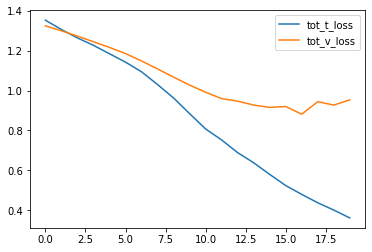

In [70]:
plt.plot(tot_t_loss, label='tot_t_loss')
plt.plot(tot_v_loss, label = 'tot_v_loss')
plt.legend()

In [71]:
print(metrics.classification_report(best_tgt, best_pred))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       179
           1       0.68      0.88      0.77       301
           2       0.81      0.56      0.67       259
           3       0.44      0.39      0.41       140

    accuracy                           0.66       879
   macro avg       0.64      0.62      0.62       879
weighted avg       0.67      0.66      0.65       879

